![text](header.png)

### MLP-based model compression 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-02 19:38:01.218137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2025-04-02 19:38:12.889478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-04-02 19:38:13.373743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 19:38:13.373878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.155GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 149.04GiB/s
2025-04-02 19:38:13.373920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-02 19:38:13.375331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-02 19:38:13.375392: I tensorflow/s

#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

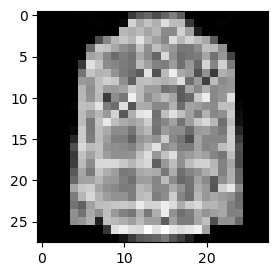

In [4]:
# Image index

N = 32

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [5]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Load model



In [6]:
model = load_model('fashionMNIST.h5')

2025-04-02 19:38:50.829114: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-02 19:38:50.854580: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2304000000 Hz
2025-04-02 19:38:50.855379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4bc49a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-04-02 19:38:50.855392: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-04-02 19:38:50.916134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retu

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
_________________________________________________________________


In [8]:
n_classes = 10
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Pruning

In [17]:
epochs = 64
batch = 64
lr = 0.0001
op = Adam(lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
val_split = 0.2

final_sparsity = 0.2


## PolynomialDecay: gradually increases the sparsity of a model over time using a polynomial function. 
# This helps in iterative pruning, where pruning is applied progressively rather than all at once, 
# improving accuracy retention.

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=1000
                )
            }

In [18]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


### Model training

In [19]:
history = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/64
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

In [20]:
# Model evaluation
test_loss, test_acc = modelP.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

  1/313 [..............................] - ETA: 3s - loss: 1.7921 - accuracy: 0.8750

313/313 [==============================] - 0s 842us/step - loss: 1.0126 - accuracy: 0.8927

Test accuracy: 0.8927


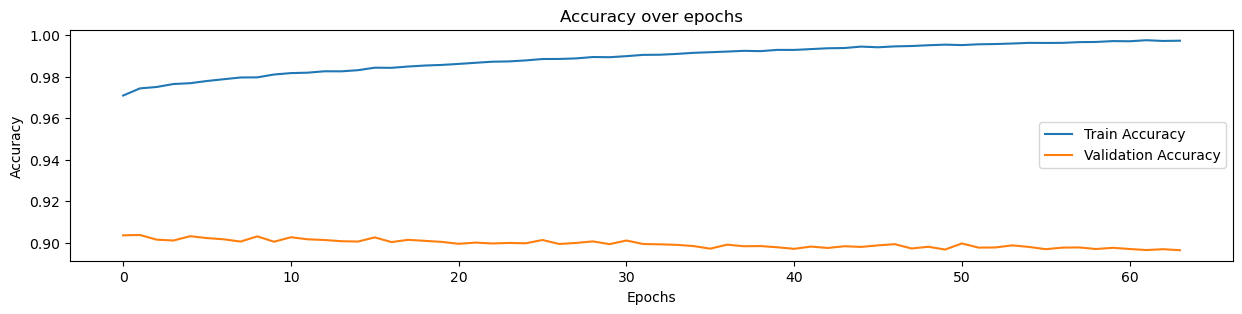

In [21]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

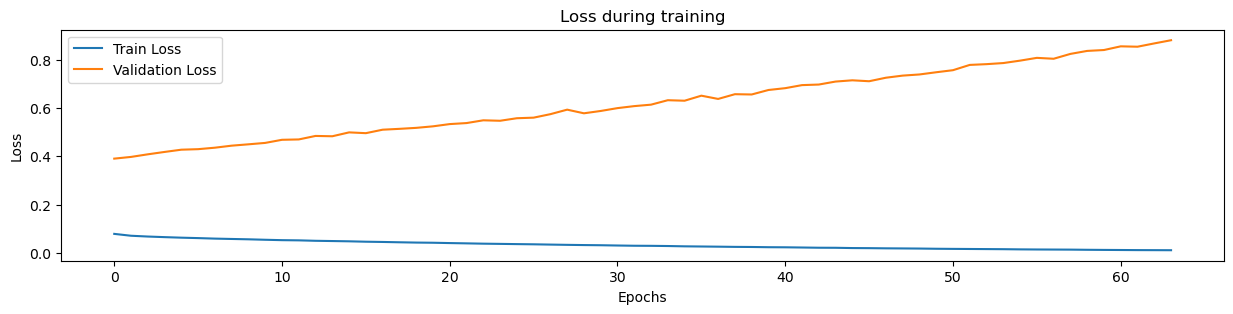

In [22]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Confusion Matrix

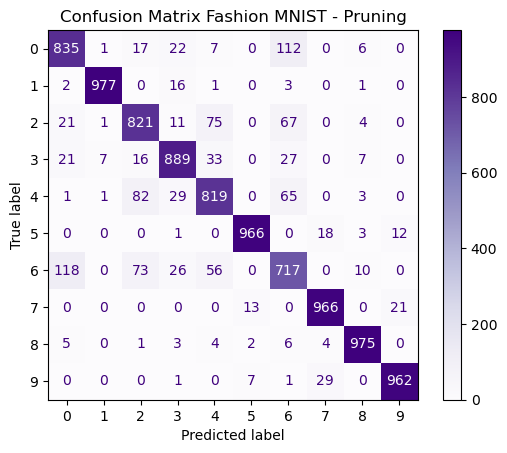

In [23]:
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix Fashion MNIST - Pruning')
plt.show()


### Quantization-aware training

QDense: A quantized version of Dense.

quantized_bits(N, M, alpha):

- N: Total bits used.

- M: Bits for the fractional part.

- alpha: Scaling factor.

QActivation: Applies quantized activations such as quantized_relu and quantized_softmax.

In [29]:

kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(250, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(100, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

In [30]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
fc1 (QDense)                 (None, 250)               196250    
_________________________________________________________________
relu1 (QActivation)          (None, 250)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 250)               0         
_________________________________________________________________
fc2 (QDense)                 (None, 100)               25100     
_________________________________________________________________
relu2 (QActivation)          (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)            

In [31]:
# Training (QAT)

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
H = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )


Epoch 1/16
750/750 [==============================] - 2s 2ms/step - loss: 2.3188 - accuracy: 0.6349 - val_loss: 0.6550 - val_accuracy: 0.8055
Epoch 2/16
750/750 [==============================] - 1s 1ms/step - loss: 0.7480 - accuracy: 0.7687 - val_loss: 0.6094 - val_accuracy: 0.8033
Epoch 3/16
750/750 [==============================] - 1s 1ms/step - loss: 0.6808 - accuracy: 0.7801 - val_loss: 0.5611 - val_accuracy: 0.8133
Epoch 4/16
750/750 [==============================] - 1s 1ms/step - loss: 0.6335 - accuracy: 0.7897 - val_loss: 0.5463 - val_accuracy: 0.8153
Epoch 5/16
750/750 [==============================] - 1s 1ms/step - loss: 0.6221 - accuracy: 0.7939 - val_loss: 0.6135 - val_accuracy: 0.7989
Epoch 6/16
750/750 [==============================] - 1s 1ms/step - loss: 0.6216 - accuracy: 0.7927 - val_loss: 0.5591 - val_accuracy: 0.8182
Epoch 7/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5959 - accuracy: 0.7983 - val_loss: 0.5719 - val_accuracy: 0.8154
Epoch 

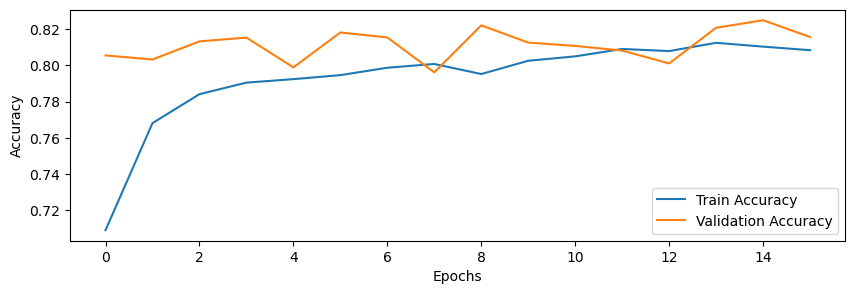

In [35]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

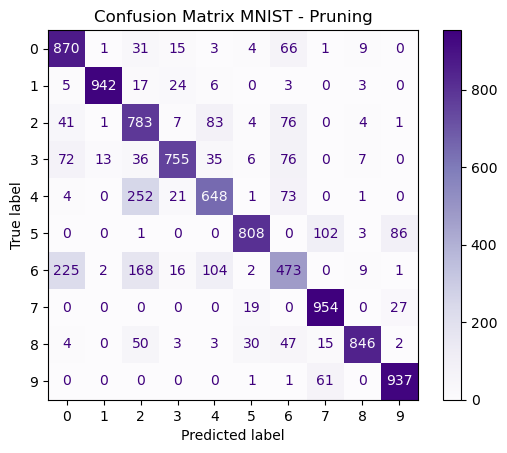

In [36]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()


---
#### Mar del Plata, Argentina - 2025

Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy